## Downloading and Importing Relevant Libraries

!pip3 install numpy --quiet
!pip3 install pandas --quiet
!pip3 install yfinance --quiet
!pip3 install matplotlib --quiet 
!pip3 install scikit-learn --quiet 
!pip3 install tensorflow --quiet

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

## Downloading stock data for a particular ticker and timeframe.

In [2]:
ticker = "NVDA" 
start_date = "2019-11-25"
end_date = "2024-12-18"
nvda = yf.download(ticker, start=start_date, end=end_date)
nvda

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,NVDA,NVDA,NVDA,NVDA,NVDA,NVDA
Date,,,,,,
2019-11-25,5.503102,5.530250,5.535250,5.388000,5.401000,506476000
2019-11-26,5.398369,5.425000,5.517250,5.418500,5.512500,385244000
2019-11-27,5.433222,5.456000,5.501250,5.429500,5.466750,215784000
2019-11-29,5.395879,5.418500,5.453500,5.394500,5.425000,141556000
2019-12-02,5.209411,5.231250,5.425000,5.216000,5.411500,372036000
...,...,...,...,...,...,...
2024-12-11,139.309998,139.309998,140.169998,135.210007,137.360001,184905200
2024-12-12,137.339996,137.339996,138.440002,135.800003,137.080002,159211400


## Visualizing the closing stock price of NVDA within our set time frame.

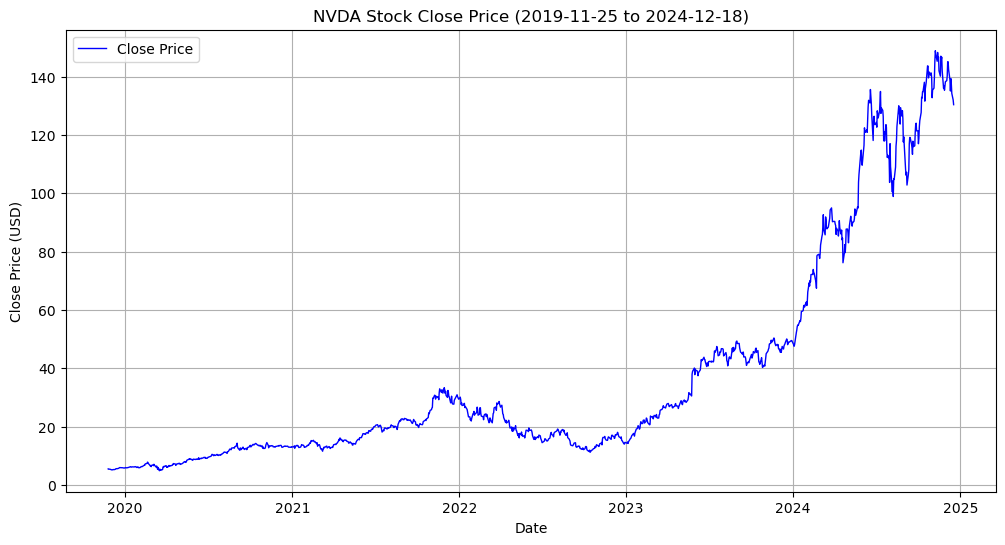

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(nvda.index, nvda['Close'], color='blue', linewidth=1, label='Close Price')

# Add labels and title
plt.title(f"{ticker} Stock Close Price ({start_date} to {end_date})")
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.grid(True)

## Data Preprocessing
#### LSTMs are sensitive to the scale of the data. Therefore, we need to apply the MinMax Scalar.

In [4]:
from sklearn.preprocessing import MinMaxScaler

nvda_close = nvda['Close'].values # Grabs the closing prices and stores it into a new dataframe
scaler = MinMaxScaler(feature_range=(0,1)) # Initializes the scalar that scales values from 0 to 1 
nvda_close = scaler.fit_transform(np.array(nvda_close).reshape(-1, 1)) # Applies the scalar on 'nvda_close' to scale values to between 0 and 1.

In [5]:
# Splits the data into the training, val, and testing set

train_val_set = nvda_close[:int(0.9 * len(nvda_close))] 
train_set = train_val_set[:int(0.8 * len(train_val_set))]
val_set = train_val_set[int(0.8 * len(train_val_set)):]
test_set = nvda_close[int(0.9 * len(nvda_close)):] 

print(len(train_val_set))
print(len(train_set))
print(len(val_set))
print(len(test_set))

1146
916
230
128


In [6]:
def build_sequences(data, time_step):
    """Builds the time-step sequences to feed into the LSTM model."""
    X, Y = [], []
    for i in range(len(data) - time_step):
        input = data[i : i + time_step]
        target = data[i + time_step]

        X.append(input), Y.append(target)
    return np.array(X), np.array(Y)

In [7]:
time_step = 60

X_train, Y_train = build_sequences(train_set, time_step)
X_val, Y_val = build_sequences(val_set, time_step)
X_test, Y_test = build_sequences(test_set, time_step)

#### Reshaping the data because an LSTM requires a 3D input shape: (number of samples, timesteps, number of features)

In [8]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [9]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [10]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (60,1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
early_stopping = keras.callbacks.EarlyStopping(monitor= 'val_loss', patience=3, restore_best_weights=True)
model.fit(X_train,Y_train,validation_data=(X_val,Y_val),epochs=100,batch_size=10, verbose=1, callbacks=[early_stopping])

Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 2.0494e-04 - val_loss: 0.0020
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 1.8198e-04 - val_loss: 0.0038
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.8076e-04 - val_loss: 9.5695e-04
Epoch 5/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 1.4983e-04 - val_loss: 0.0011
Epoch 6/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 1.4548e-04 - val_loss: 0.0012
Epoch 7/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 1.1594e-04 - val_loss: 0.0010


In [12]:
predictions = model.predict(X_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


In [13]:
predictions = scaler.inverse_transform(predictions)

In [14]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score

# print("Root Mean Squared Error for Train: "+ str(root_mean_squared_error(Y_train, train_predict)))
print("Root Mean Squared Error for Test: "+ str(root_mean_squared_error(Y_test, predictions)))

# print("Mean Absolute Error for Train: "+ str(mean_absolute_error(Y_train, train_predict)))
print("Mean Absolute Error for Test: "+ str(mean_absolute_error(Y_test, predictions)))

# print("R-Squared for Train: "+ str(r2_score(Y_train, train_predict)))
print("R-Squared for Test: "+ str(r2_score(Y_test, predictions)))

Root Mean Squared Error for Test: 138.20827501256034
Mean Absolute Error for Test: 137.689017617405
R-Squared for Test: -4018332.327568458


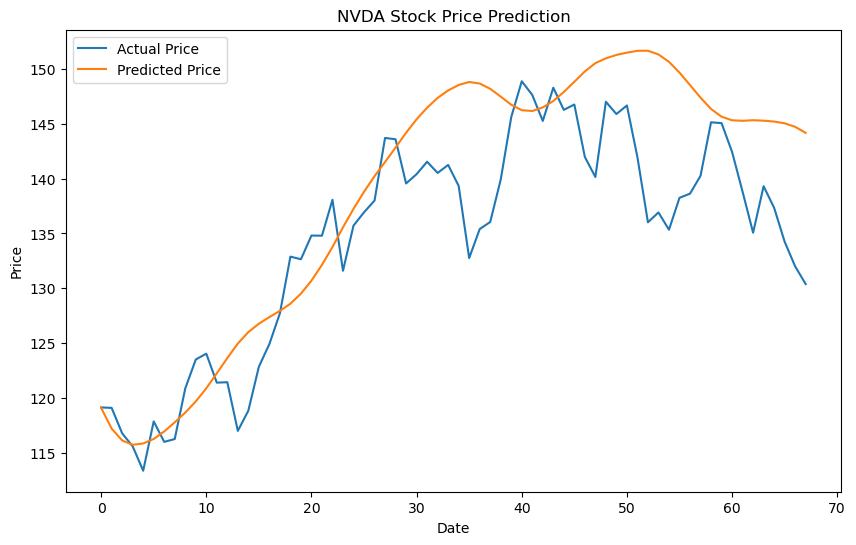

In [15]:
y_test_actual = scaler.inverse_transform(Y_test.reshape(-1, 1))

plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('NVDA Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()